# Import libraries

In [113]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import seaborn as sns
import umap


# Load Students' Dropout and Academic Success

In [114]:
df = pd.read_csv('https://archive.ics.uci.edu/static/public/697/data.csv')
print("Dataset Head:")
print(df.head())

Dataset Head:
   Marital Status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                       

# Data characteristics

To understand the shape of data, data type, missingness, unique entries for each feature and label, and distribution of each unique entries.

In [115]:

# Display basic information about the dataset
print("Basic Information:")
df.info()

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display unique values in each column
print("\nUnique Entries:")
for col in df:
    print(col)
    print(df[col].unique())
    print('\n')

# Display the frequency of each unique values in each column
print("\nFrequency of Unique Entries:")
for col in df:
    print(f"\nFrequency of values in {col}:")
    print(df[col].value_counts())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification

# Segregate data

In [116]:
# Segregate the data base on its type
cat = [
    "Marital Status", 
    "Application mode", 
    "Course",
    "Previous qualification", 
    "Nacionality", 
    "Mother's qualification", 
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]

bin = [
    "Daytime/evening attendance",
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder",
    "International"
]

ord = [
    "Application order"
]

df_cat = df[cat + ['Target']]
df_bin = df[bin + ['Target']]
df_num = df.drop(columns=cat + bin)

# Preprocessing

Encode data base on its type and perform balance split data stratified by the labels with 70% allocated to training, and 30% for testing.

In [117]:
# Encode variables
he = OneHotEncoder()
sc = StandardScaler()
oe = OrdinalEncoder()

# Encode categorical variables and scale continuous variables
x_cat = he.fit_transform(df[cat])
x_ord = oe.fit_transform(df[ord])
x_num = df.drop(columns=cat + bin + ord + ['Target'])
x_num = sc.fit_transform(x_num)


# Combine encoded variables
x_bin = df[bin].to_numpy()
x = np.concatenate([x_cat.toarray(), x_bin, x_ord, x_num], axis=1)
y = df['Target'].to_numpy()

# Create training, validation, and test set
X_train, X_2, y_train, y_2 = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_2, y_2, test_size=0.5, random_state=0, stratify=y_2)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3096, 247)
(664, 247)
(664, 247)


In [118]:
# Apply SMOTE to the training and validation data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_val_res, y_val_res = smote.fit_resample(X_val, y_val)
print(X_train_res.shape)
print(X_val_res.shape)

(4638, 247)
(996, 247)


In [119]:
# Prepare data for dimension reduction
X_train_res_num = X_train_res[:, -len(x_num[0]):]
X_val_res_num = X_val_res[:, -len(x_num[0]):]

X_train_res_nonum = X_train_res[:, :-len(x_num[0])]
X_val_res_nonum = X_val_res[:, :-len(x_num[0])]

X_test_num = X_test[:, -len(x_num[0]):]
X_test_nonum = X_test[:, :-len(x_num[0])]

print(X_train_res_num.shape)
print(X_val_res_num.shape)
print(X_test_num.shape)

print(X_train_res_nonum.shape)
print(X_val_res_nonum.shape)
print(X_test_nonum.shape)

(4638, 18)
(996, 18)
(664, 18)
(4638, 229)
(996, 229)
(664, 229)


# Dimension reduction and classifiction

## PCA

### Training

In [120]:
# Perform PCA
pca = PCA(n_components=2)
X_train_res_num_agg = np.concatenate([X_train_res_num,X_val_res_num], axis=0)
X_train_res_nonum_agg = np.concatenate([X_train_res_nonum,X_val_res_nonum], axis=0)
y_train_res_agg = np.concatenate([y_train_res,y_val_res], axis=0)

X_train_res_pca = pca.fit_transform(X_train_res_num_agg, y_train_res_agg)

### Testing

(664, 231)
(5634, 231)


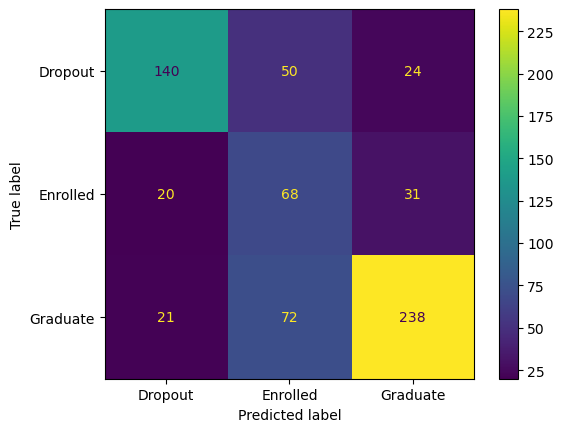

              precision    recall  f1-score   support

     Dropout       0.77      0.65      0.71       214
    Enrolled       0.36      0.57      0.44       119
    Graduate       0.81      0.72      0.76       331

    accuracy                           0.67       664
   macro avg       0.65      0.65      0.64       664
weighted avg       0.72      0.67      0.69       664



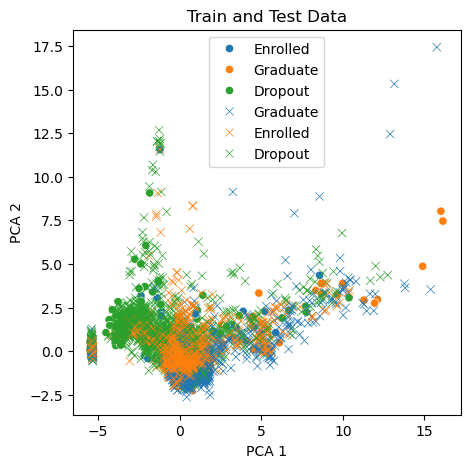

In [121]:
# Conduct PCA for testing
X_test_num_pca = pca.transform(X_test_num)
X_test_pca = np.concatenate([X_test_num_pca, X_test_nonum], axis=1)
print(X_test_pca.shape)

# Combine the reduced data with the non-reduced data
X_train_res_pca = np.concatenate([X_train_res_pca, X_train_res_nonum_agg], axis=1)
print(X_train_res_pca.shape)

# Perform logistic regression
lr = LogisticRegression(max_iter=1000)
mdl = lr.fit(X_train_res_pca, y_train_res_agg)
y_pred = mdl.predict(X_test_pca)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=lr.classes_)
disp.plot()
plt.show()

# Display classification report
report = classification_report(y_test, y_pred)
print(report)

#Display plot of train and test models
plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test)
sns.scatterplot(x=X_train_res_pca[:, 0], y=X_train_res_pca[:, 1], hue=y_train_res_agg, marker='x')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Train and Test Data")
plt.show()

## LDA

### Training

In [122]:
# Perform LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_res_lda = lda.fit_transform(X_train_res_num_agg, y_train_res_agg)

### Testing

(664, 231)
(5634, 231)


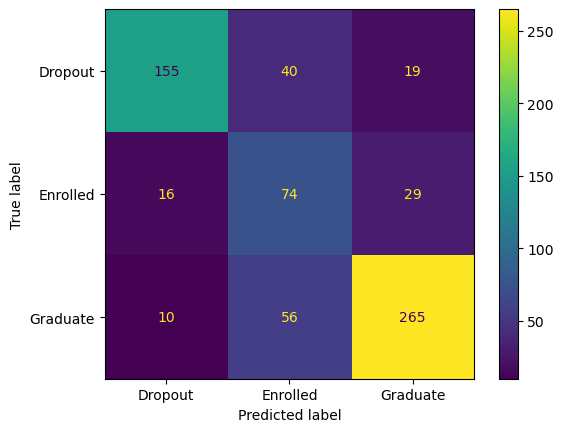

              precision    recall  f1-score   support

     Dropout       0.86      0.72      0.78       214
    Enrolled       0.44      0.62      0.51       119
    Graduate       0.85      0.80      0.82       331

    accuracy                           0.74       664
   macro avg       0.71      0.72      0.71       664
weighted avg       0.78      0.74      0.75       664



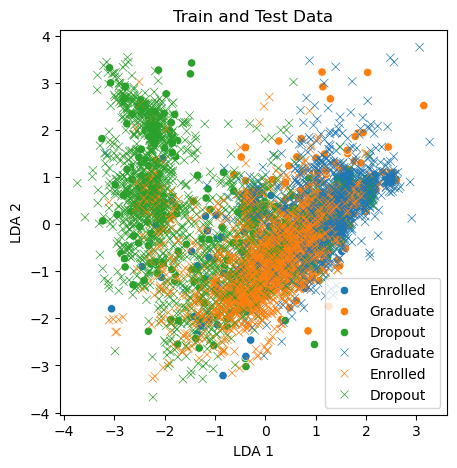

In [123]:
# Conduct LDA for testing
X_test_num_lda = lda.transform(X_test_num)
X_test_lda = np.concatenate([X_test_num_lda, X_test_nonum], axis=1)
print(X_test_lda.shape)

# Combine the reduced data with the non-reduced data
X_train_res_lda = np.concatenate([X_train_res_lda, X_train_res_nonum_agg], axis=1)
print(X_train_res_lda.shape)

# Perform logistic regression
lr = LogisticRegression(max_iter=1000)
mdl = lr.fit(X_train_res_lda, y_train_res_agg)
y_pred = mdl.predict(X_test_lda)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=lr.classes_)
disp.plot()
plt.show()

# Display classification report
report = classification_report(y_test, y_pred)
print(report)

#Display plot of train and test models
plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_test_lda[:, 0], y=X_test_lda[:, 1], hue=y_test)
sns.scatterplot(x=X_train_res_lda[:, 0], y=X_train_res_lda[:, 1], hue=y_train_res_agg, marker='x')
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.title("Train and Test Data")
plt.show()

## Kernel PCA

### Training

In [124]:
# Define desired dimension
desired_dim = 2

gamma = 0
max_acc = 0
tr_acc = 0

for i in range(1, 10):
    gamma_value = i / 10

    # Apply kernel PCA
    kpca = KernelPCA(n_components=desired_dim, kernel='rbf', gamma=gamma_value)
    X_train_num_kpca = kpca.fit_transform(X_train_res_num)
    X_val_num_kpca = kpca.transform(X_val_res_num)

    # Combine the reduced numerical data with the non-numerical data
    X_train_kpca = np.concatenate((X_train_res_nonum, X_train_num_kpca), axis=1)
    X_val_kpca = np.concatenate((X_val_res_nonum, X_val_num_kpca), axis=1)

    # Perform logistic regression
    lr = LogisticRegression(max_iter=1000)
    mdl = lr.fit(X_train_kpca, y_train_res)

    train_acc = mdl.score(X_train_kpca,y_train_res)
    val_acc = mdl.score(X_val_kpca,y_val_res)
    print(f"Gamma value: {gamma_value}")
    print(f"\tTraining accuracy: {train_acc}")
    print(f"\tValidation accuracy: {val_acc}")
    if val_acc > max_acc:
        gamma = gamma_value
        max_acc = val_acc
        tr_acc = train_acc

print(f"Best gamma value: {gamma}")

Gamma value: 0.1
	Training accuracy: 0.684346701164295
	Validation accuracy: 0.5953815261044176
Gamma value: 0.2
	Training accuracy: 0.6660198361362656
	Validation accuracy: 0.5783132530120482
Gamma value: 0.3
	Training accuracy: 0.6582578697714532
	Validation accuracy: 0.5742971887550201
Gamma value: 0.4
	Training accuracy: 0.6550237171194481
	Validation accuracy: 0.5753012048192772
Gamma value: 0.5
	Training accuracy: 0.6548081069426477
	Validation accuracy: 0.5793172690763052
Gamma value: 0.6
	Training accuracy: 0.6554549374730487
	Validation accuracy: 0.5763052208835341
Gamma value: 0.7
	Training accuracy: 0.6522207848210435
	Validation accuracy: 0.571285140562249
Gamma value: 0.8
	Training accuracy: 0.6530832255282449
	Validation accuracy: 0.5672690763052208
Gamma value: 0.9
	Training accuracy: 0.6528676153514446
	Validation accuracy: 0.570281124497992
Best gamma value: 0.1


### Testing

Best gamma value: 0.1
Best training accuracy: 0.684346701164295
Best validation accuracy: 0.5953815261044176


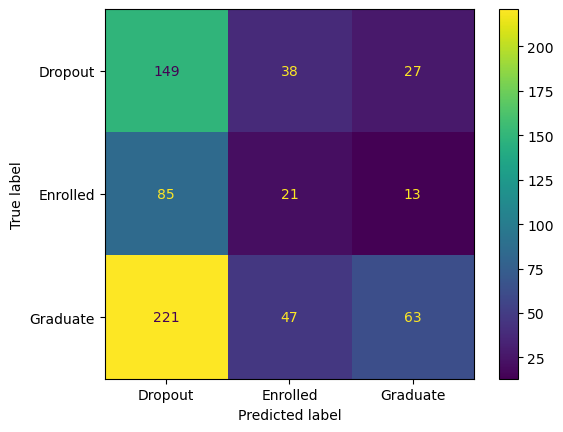

              precision    recall  f1-score   support

     Dropout       0.33      0.70      0.45       214
    Enrolled       0.20      0.18      0.19       119
    Graduate       0.61      0.19      0.29       331

    accuracy                           0.35       664
   macro avg       0.38      0.35      0.31       664
weighted avg       0.45      0.35      0.32       664



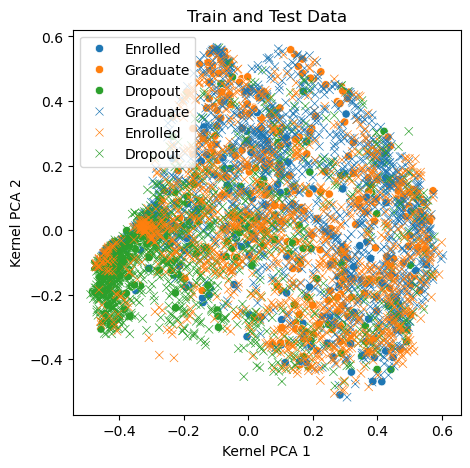

In [125]:
print(f"Best gamma value: {gamma}")
print(f"Best training accuracy: {tr_acc}")
print(f"Best validation accuracy: {max_acc}")

# Conduct Kernel PCA on the test data
best = KernelPCA(n_components=desired_dim, kernel='rbf', gamma=gamma)
X_train_num_kpca = best.fit_transform(X_train_res_num)
X_test_num_kpca = best.transform(X_test_num)

# Combine the reduced numerical data with the non-numerical data
X_test_kpca = np.concatenate((X_test_num_kpca, X_test_nonum), axis=1)

# Use the logistic regression model to make predictions
y_pred = lr.predict(X_test_kpca)
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()
plt.show()

report = classification_report(y_test, y_pred)
print(report)

#Display plot of train and test models
plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_test_kpca[:, 0], y=X_test_kpca[:, 1], hue=y_test)
sns.scatterplot(x=X_train_num_kpca[:, 0], y=X_train_num_kpca[:, 1], hue=y_train_res, marker='x')
plt.xlabel("Kernel PCA 1")
plt.ylabel("Kernel PCA 2")
plt.title("Train and Test Data")
plt.show()

## LLE

### Training

In [126]:
# Define desired dimension
desired_dim = 2

f_neighbor = 0
max_acc = 0
tr_acc = 0

for neighbors in range(1, 10):

    # Apply LLE
    lle = LocallyLinearEmbedding(n_components=desired_dim, n_neighbors=neighbors, method='standard', eigen_solver='dense')
    X_train_num_lle = lle.fit_transform(X_train_res_num)
    X_val_num_lle = lle.transform(X_val_res_num)

    # Combine the reduced numerical data with the non-numerical data
    X_train_lle = np.concatenate((X_train_res_nonum, X_train_num_lle), axis=1)
    X_val_lle = np.concatenate((X_val_res_nonum, X_val_num_lle), axis=1)

    # Perform logistic regression
    lr = LogisticRegression(max_iter=1000)
    mdl = lr.fit(X_train_lle, y_train_res)

    train_acc = mdl.score(X_train_lle,y_train_res)
    val_acc = mdl.score(X_val_lle,y_val_res)
    print(f"Neighbors value: {neighbors}")
    print(f"\tTraining accuracy: {train_acc}")
    print(f"\tValidation accuracy: {val_acc}")
    if val_acc > max_acc:
        f_neighbor = neighbors
        max_acc = val_acc
        tr_acc = train_acc

print(f"Best neighbor value: {f_neighbor}")

Neighbors value: 1
	Training accuracy: 0.6446744286330315
	Validation accuracy: 0.5652610441767069
Neighbors value: 2
	Training accuracy: 0.6451056489866321
	Validation accuracy: 0.5692771084337349
Neighbors value: 3
	Training accuracy: 0.6455368693402329
	Validation accuracy: 0.5642570281124498
Neighbors value: 4
	Training accuracy: 0.6470461405778353
	Validation accuracy: 0.5692771084337349
Neighbors value: 5
	Training accuracy: 0.6446744286330315
	Validation accuracy: 0.5632530120481928
Neighbors value: 6
	Training accuracy: 0.6507115135834411
	Validation accuracy: 0.5692771084337349
Neighbors value: 7
	Training accuracy: 0.6440275981026304
	Validation accuracy: 0.5652610441767069
Neighbors value: 8
	Training accuracy: 0.6442432082794308
	Validation accuracy: 0.5652610441767069
Neighbors value: 9
	Training accuracy: 0.6463993100474342
	Validation accuracy: 0.5652610441767069
Best neighbor value: 2


### Testing

Best neighbor value: 2
Best training accuracy: 0.6451056489866321
Best validation accuracy: 0.5692771084337349


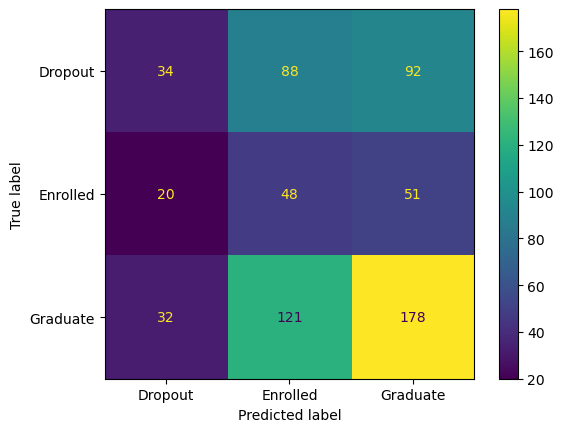

              precision    recall  f1-score   support

     Dropout       0.40      0.16      0.23       214
    Enrolled       0.19      0.40      0.26       119
    Graduate       0.55      0.54      0.55       331

    accuracy                           0.39       664
   macro avg       0.38      0.37      0.34       664
weighted avg       0.44      0.39      0.39       664



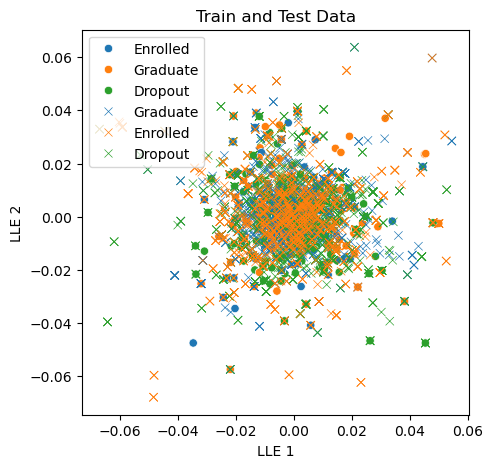

In [127]:
print(f"Best neighbor value: {f_neighbor}")
print(f"Best training accuracy: {tr_acc}")
print(f"Best validation accuracy: {max_acc}")

# Conduct LLE on the test data
best = LocallyLinearEmbedding(n_components=desired_dim, n_neighbors=f_neighbor, method='standard', eigen_solver='dense')
X_train_num_lle = best.fit_transform(X_train_res_num)
X_test_num_lle = best.transform(X_test_num)

# Combine the reduced numerical data with the non-numerical data
X_test_lle = np.concatenate((X_test_num_lle, X_test_nonum), axis=1)

# Use the logistic regression model to make predictions
y_pred = lr.predict(X_test_lle)
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()
plt.show()

report = classification_report(y_test, y_pred)
print(report)

#Display plot of train and test models
plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_test_lle[:, 0], y=X_test_lle[:, 1], hue=y_test)
sns.scatterplot(x=X_train_num_lle[:, 0], y=X_train_num_lle[:, 1], hue=y_train_res, marker='x')
plt.xlabel("LLE 1")
plt.ylabel("LLE 2")
plt.title("Train and Test Data")
plt.show()

## UMAP with Euclidean metric

### Training

In [128]:
# Perform UMAP with Euclidean metric
umap_euc = umap.UMAP(n_components=2, metric='euclidean', random_state=42)

# Encode target labels
y_train_res_agg_encoded = oe.fit_transform(y_train_res_agg.reshape(-1, 1)).ravel()
y_test_encoded = oe.transform(y_test.reshape(-1, 1)).ravel()

# Fit model
X_train_res_umap_euc = umap_euc.fit_transform(X_train_res_num_agg, y_train_res_agg_encoded)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Testing

(664, 231)
(5634, 231)


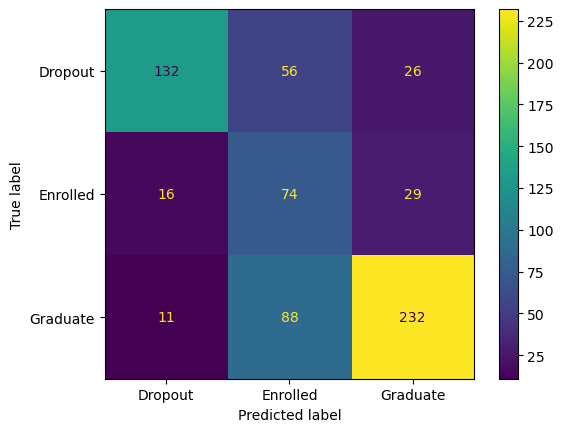

              precision    recall  f1-score   support

         0.0       0.83      0.62      0.71       214
         1.0       0.34      0.62      0.44       119
         2.0       0.81      0.70      0.75       331

    accuracy                           0.66       664
   macro avg       0.66      0.65      0.63       664
weighted avg       0.73      0.66      0.68       664



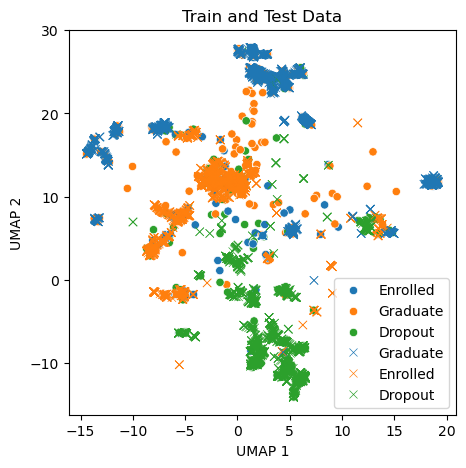

In [129]:
# Conduct UMAP for testing
X_test_num_umap_euc = umap_euc.transform(X_test_num)
X_test_umap_euc = np.concatenate([X_test_num_umap_euc, X_test_nonum], axis=1)
print(X_test_umap_euc.shape)

# Combine the reduced data with the non-reduced data
X_train_res_umap_euc = np.concatenate([X_train_res_umap_euc, X_train_res_nonum_agg], axis=1)
print(X_train_res_umap_euc.shape)

# Perform logistic regression
lr = LogisticRegression(max_iter=1000)
mdl = lr.fit(X_train_res_umap_euc, y_train_res_agg_encoded)
y_pred = mdl.predict(X_test_umap_euc)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_pred), display_labels= ["Dropout", "Enrolled", "Graduate"])
disp.plot()
plt.show()

# Display classification report
report = classification_report(y_test_encoded, y_pred)
print(report)

#Display plot of train and test models
plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_test_umap_euc[:, 0], y=X_test_umap_euc[:, 1], hue=y_test)
sns.scatterplot(x=X_train_res_umap_euc[:, 0], y=X_train_res_umap_euc[:, 1], hue=y_train_res_agg, marker='x')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Train and Test Data")
plt.show()

## UMAP with Euclidean metric and Hamming metric

### Training

In [130]:
# UMAP for Hamming metric
umap_ham = umap.UMAP(n_components=2, metric='hamming', random_state=42)
X_train_res_nonum_agg = np.concatenate([X_train_res_nonum, X_val_res_nonum], axis=0)

#Fit model with Euclidean and Hamming metric
X_train_res_umap_ham = umap_ham.fit_transform(X_train_res_nonum_agg, y_train_res_agg_encoded)
X_train_res_umap_euc = umap_euc.fit_transform(X_train_res_num_agg, y_train_res_agg_encoded)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Testing

(664, 4)
(5634, 4)


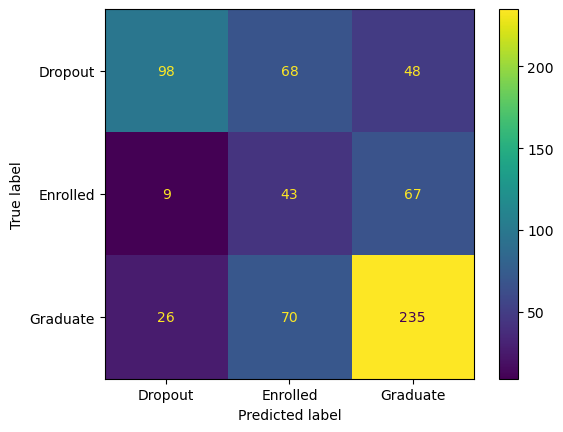

              precision    recall  f1-score   support

         0.0       0.74      0.46      0.56       214
         1.0       0.24      0.36      0.29       119
         2.0       0.67      0.71      0.69       331

    accuracy                           0.57       664
   macro avg       0.55      0.51      0.51       664
weighted avg       0.61      0.57      0.58       664



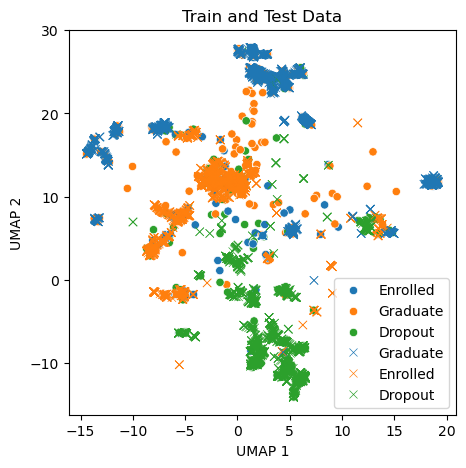

In [131]:
# Conduct UMAP with Euclidean and Hamming metric for testing
X_test_num_umap_euc = umap_euc.transform(X_test_num)
X_test_num_umap_ham = umap_ham.transform(X_test_nonum)

X_test_umap_euc_ham = np.concatenate([X_test_num_umap_euc, X_test_num_umap_ham], axis=1)
print(X_test_umap_euc_ham.shape)

# Combine the reduced data with the non-reduced data
X_train_res_umap_euc_ham = np.concatenate([X_train_res_umap_euc, X_train_res_umap_ham], axis=1)
print(X_train_res_umap_euc_ham.shape)

# Perform logistic regression
lr = LogisticRegression(max_iter=1000)
mdl = lr.fit(X_train_res_umap_euc_ham, y_train_res_agg_encoded)
y_pred = mdl.predict(X_test_umap_euc_ham)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_pred), display_labels= ["Dropout", "Enrolled", "Graduate"])
disp.plot()
plt.show()

# Display classification report
report = classification_report(y_test_encoded, y_pred)
print(report)

#Display plot of train and test models
plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_test_umap_euc[:, 0], y=X_test_umap_euc[:, 1], hue=y_test)
sns.scatterplot(x=X_train_res_umap_euc[:, 0], y=X_train_res_umap_euc[:, 1], hue=y_train_res_agg, marker='x')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Train and Test Data")
plt.show()

# Conclusion

For this exercise, interestingly, linear dimension reduction model yielded the highest accuracy compared to non-linear dimension reduction models. However, the difference in accuracy is minimal in some models. In particular, LDA, the ranked first model has a weighted accuracy of 0.78 followed by UMAP with Euclidean metric with a weighted accuracy of 0.73.